# Example of usage

Here is one example on how to use interpretation techniques with 1D signals like ECG.

In [1]:
%load_ext autoreload
%autoreload 2

# basic libraries to use
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import signal_screen
import signal_screen_tools

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Flatten, BatchNormalization, Input
from tensorflow.keras.callbacks import ModelCheckpoint

## Data preprocessing
* data used: preprocessed data from [kaggle.com](https://www.kaggle.com/shayanfazeli/heartbeat) with origin at [MIT-BIT arrhythmia database](https://www.physionet.org/content/mitdb/1.0.0/)
* data are already normalised 0-1 and framed to equal length
* classifications are placed at last column:
  * 0 - nonectopic - N
  * 1 - supraventricular ectopic beat - S
  * 2 - ventricular ectopic beat - V
  * 3 - fusion beat - F
  * 4 - unknown - Q
* counts:
  * N: 72471
  * S: 2223
  * V: 5788
  * F: 641
  * Q: 6431

In [2]:
# load data
data_train = pd.read_csv("archive/mitbih_train.csv", sep=",", header=None).to_numpy()
data_test = pd.read_csv("archive/mitbih_test.csv", sep=",", header=None).to_numpy()

# get X and y
X_train, y_train = data_train[:, :data_train.shape[1]-2], data_train[:, -1]
X_test, y_test = data_test[:, :data_test.shape[1]-2], data_test[:, -1]

# number of categories
num_of_categories = np.unique(y_train).shape[0]

del data_train, data_test

#indexing examples to show visualisations
examples_to_visualise = [np.where(y_test == i)[0][0] for i in range(5)]
titles = [ "nonectopic", "supraventricular ectopic beat", "ventricular ectopic beat", "fusion beat", "unknown"]

# creation of tensors
X_train = np.expand_dims(tf.convert_to_tensor(X_train), axis=2)
X_test = np.expand_dims(tf.convert_to_tensor(X_test), axis=2)

# one-hot encoding for 5 categories
y_train = tf.one_hot(y_train, num_of_categories)
y_test = tf.one_hot(y_test, num_of_categories)

## Model

Basic convolutional model with 3 1D conv layers, one max-pooling and batch normalisations.
At the end dense layers to classify categories.

In [3]:
# basic model
model = Sequential([
    Input(shape=[X_train.shape[1], 1]),
    Conv1D(filters=16, kernel_size=3, activation="relu"),
    BatchNormalization(),
    MaxPool1D(),
    Conv1D(filters=32, kernel_size=3, activation="relu"),
    BatchNormalization(),
    Conv1D(filters=64, kernel_size=3, activation="relu"),
    BatchNormalization(),
    Flatten(),
    Dense(20, activation="relu"),
    Dense(num_of_categories, activation="softmax")
]
)

# train process

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

checkPoint = ModelCheckpoint(filepath="model.h5", save_weights_only=False, monitor='val_accuracy',
                            mode='max', save_best_only=True)

model.fit(x=np.expand_dims(X_train, axis=2), y=y_train,
          batch_size=128, epochs=10, validation_data=(np.expand_dims(X_test, axis=2), y_test),
          callbacks=[checkPoint])

Epoch 1/10
685/685 [==============================] - 3s 5ms/step - loss: 0.1544 - accuracy: 0.9576 - val_loss: 0.1100 - val_accuracy: 0.9696

In [3]:
model = tf.keras.models.load_model("model.h5")
loss, acc = model.evaluate(np.expand_dims(X_test, axis=2), y_test)

685/685 [==============================] - 1s 2ms/step - loss: 0.0907 - accuracy: 0.9777

## Occlusion sensitivity
Basic principle:
* we have frame of zeros, which is gradually moved through the signal
* if we delete important part of the signal -> the result of the neural network will change
* we can subtract this result from reference and get changes in accuracy through whole signal, which can be visualised
* reference:     https://arxiv.org/abs/1311.2901

We picked from every category one signal and watched, what will happen to output of the neural network. Gradient plot
tool can be used from "signal_screen_tools" to show changing of the output with template signal.

Occlusion sensitivity for 15 samples and class 4: 100%|██████████| 186/186 [00:04<00:00, 38.08it/s]


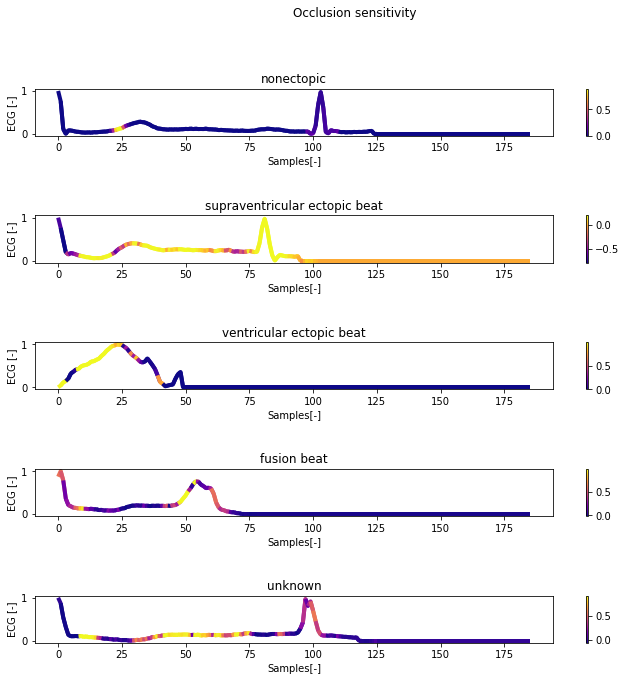

In [5]:
fig, axs = plt.subplots(nrows=5, ncols=1)
fig.suptitle("Occlusion sensitivity")
fig.tight_layout()
fig.set_size_inches(10, 10)
axs = axs.ravel()

for c, row, ax, title in zip(range(5), examples_to_visualise, axs, titles):
    # pass model and input for the model - multiple inputs could be done by e.g. np.expand_dims(X_test[5:10, :], axis=(2))
    sensitivity, _ = signal_screen.calculate_occlusion_sensitivity(model=model,
                                                         data=np.expand_dims(X_test[row, :], axis=(0, 2)),
                                                         c=c,
                                                         number_of_zeros=[15])

    # create gradient plot
    signal_screen_tools.plot_with_gradient(ax=ax, y=X_test[row, :].ravel(), gradient=sensitivity[0], title=title)
    ax.set_xlabel("Samples[-]")
    ax.set_ylabel("ECG [-]")

plt.show()


## Saliency map
* Saliency maps or sometimes referred to as the vanilla gradient method use a simple idea to identify the regions in the image that are important
* In this technique, the derivative of the outputs with respect to the actual input over the whole model are calculated. Thus, we describe, for example, how changes in values in individual signals change our output.
* math expression: $$ saliency = \frac{\partial y^c}{\partial input} $$
* High values directly describe that a given value contributes to a given result, which we can then visualize.
* Prior to the application of this method, in order to maintain at least a minimum linear dependence between input and output, the activation function of the output layer was replaced by a linear one. (It is recommended to store model before using this library)
* reference: https://arxiv.org/abs/1312.6034

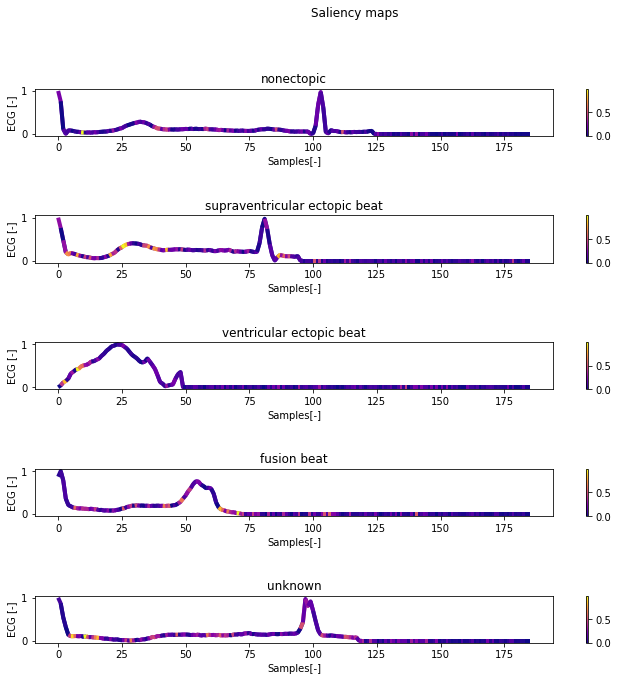

In [6]:
fig, axs = plt.subplots(nrows=5, ncols=1)
fig.suptitle("Saliency maps")
fig.tight_layout()
fig.set_size_inches(10, 10)
axs = axs.ravel()

for c, row, ax, title in zip(range(5), examples_to_visualise, axs, titles):
    # pass model and input for the model - multiple inputs could be done by e.g. X_test[5:10, :] and average outputs
    saliency_map = signal_screen.calculate_saliency_map(model=model,
                                                        data=np.expand_dims(X_test[row, :], axis=0),
                                                        c=c)
    # create gradient plot
    signal_screen_tools.plot_with_gradient(ax=ax, y=X_test[row, :].ravel(), gradient=saliency_map, title=title)
    ax.set_xlabel("Samples[-]")
    ax.set_ylabel("ECG [-]")

plt.show()

## Grad-CAM
* Grad-CAM or gradient class activation maps are based on the principle that convolutional layers preserve spatial information. However, spatial information is lost in the interconnected layers that decide on the final classification. Therefore, activation maps can be used to track which positions at the input are relevant to our particular classification.
* It is possible to use a gradient leading to the last layer of the output to determine the essential activation maps for classification.
* We can define importance of map by $\alpha_{k}^{c}$, where $c$ is class, $A^k$ particular activation map, $y^c$ output for picked class : $$\alpha_{k}^{c} = \frac{1}{Z} \sum_{i}\sum_{j}\frac{\partial y^{c}}{\partial A_{i,j}^{k}}$$
* To obtain the location map $L_{Grad-CAM}^c$ we then use a linear combination of these weights and activation maps, which we sum up. $$L_{Grad-CAM}^{c}= ReLU(\sum_k\alpha_k^c A^k )$$
* Originally, it is required that weighted summed activation maps are only positive values, which should directly contribute to the decision. This is ensured by the ReLU function.
* However, this is not always the case. Sometimes even the negative gradients can provide better interpretation than only positive gradients. You can turn off ReLU with the parameter "use_relu"
* reference: https://arxiv.org/abs/1610.02391

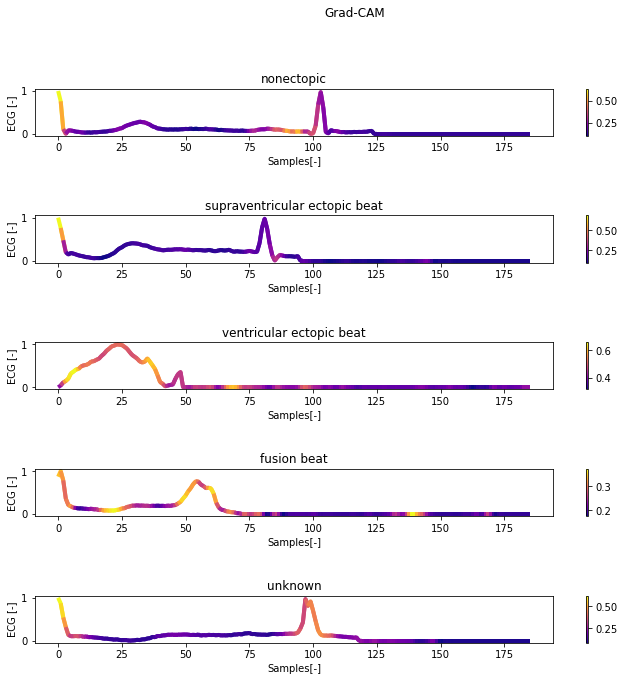

In [7]:
fig, axs = plt.subplots(nrows=5, ncols=1)
fig.suptitle("Grad-CAM")
fig.tight_layout()
fig.set_size_inches(10, 10)
axs = axs.ravel()

for c, row, ax, title in zip(range(5), examples_to_visualise, axs, titles):
    grad_cam = signal_screen.calculate_grad_cam(model=model,
                                                    data=X_test[row:row+5, :], # in case of one input, expand dims is required with axis 0
                                                    c=c,
                                                    use_relu=False)

    grad_cam = np.average(grad_cam, axis=0) # averaging outputs of grad-cam

    # create gradient plot
    signal_screen_tools.plot_with_gradient(ax=ax, y=X_test[row, :].ravel(), gradient=grad_cam, title=title)
    ax.set_xlabel("Samples[-]")
    ax.set_ylabel("ECG [-]")

plt.show()
fig.savefig("grad_cam.png")
